# Trabalho - Projeto de um classificador com atributos mistos e com dados faltantes

Nem sempre é possível termos um conjunto de dados íntegro, onde todos os dados estão padronizados e coerentes, e totalmente completos.

## O objetivo deste trabalho será responder a seguinte pergunta com o conjunto de dados:
### <div align="center"> Que pessoas tinham mais chances de sobreviver? </div>

No caso desse conjunto, temos casos onde alguns dados estão faltando.

A base de dados foi extraída do site [kaggle](https://www.kaggle.com/c/titanic/data), uma comunidade *on-line* de cientistas de dados e profissionais de aprendizado de máquina. É uma base de dados dividida em dois arquivos: conjunto de teste e uma base de treino.

No arquivo "titanic/train.csv", temos o conjunto de treinamento que tem 891 instâncias e doze colunas, o que será utilizado para a criação do modelo. Já o "titanic/test.csv" contém 418 instâncias e onze colunas, onde será utilizado para validar o desempenho do classificador em dados diferentes do treino.

#### Importando módulos importantes para o desenvolvimento do projeto

In [1]:
# bibliotecas default
import pandas as pd
import numpy as np

# bibliotecas para visualização dos dados
import seaborn as sns
import matplotlib.pyplot as plt

# bibliotecas para transformação e tratamento dos dados
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# importando os classificadares
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

**Importando o *utils* fornecido pelo professor.**

In [2]:
from utils import imprimir_estatisticas, calcular_estatisticas, rejeitar_hip_nula
from mixins import selecionar_melhor_modelo, do_cv

#### Lendo os arquivo de Teste e Treino em um *dataframe*

In [3]:
df_test = pd.read_csv("titanic/test.csv")
df_train = pd.read_csv("titanic/train.csv")

### Visualizando as 5 primeira linhas para averiguarmos com o que estamos trabalhando

In [4]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Podemos verificar que alguns dados que aparentam ser nulos.

In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


E temos uma visão de como os nossos dados estão distribuídos. Análise que algumas colunas não apareceram por serem colunas categóricas. Mas conseguimos visualizar que, por exemplo a coluna *PassengerId*, é uma coluna única, pois para cada passageiro tem um valor diferente não sendo importante na classificação visto que é algo muito específico de uma pessoa, assim como a coluna *Name*. Com isso, vamos dropar essas colunas que não ajudaram nosso classificador.

In [7]:
df_train_new = df_train.drop(columns=["PassengerId", "Name"])
df_train_new.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C


Portanto, agora estamos trabalhando com apenas 10 colunas e 891 instâncias.

## Lidando com valores faltantes

Primeiro vamos confirmar se dentro do nosso conjunto de dados existem dados faltantes, e se sim, em quais colunas eles estão distribuídos.

In [8]:
df_train_new.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [9]:
df_train_new.isnull().sum().sum()

866

Conseguimos verificar que neste conjunto temos 866 células com informação faltando. E estão distribuídos em 3 colunas diferentes: *Age*, *Cabin* e *Embarked*.

Como a coluna Embarked tem apenas 2 valores nulos, foi optado por dropar essas linhas.

In [10]:
df_train_new = df_train_new.dropna(subset=['Embarked'])
df_train_new.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


Verificando os valores nulos restantes.

In [11]:
df_train_new.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      0
dtype: int64

Agora, com as outras duas colunas (*Age* e *Cabin*) vamos fazer um tratamento especial. Na coluna *Age*, por ser um valor numérico, vamos utilizar a média de idades no lugar dos valores que estão faltando. E já na coluna *Cabin*, por estar faltando dados em quase 80% das linhas e ser categórico, foi escolhido imputar com valor padrão, sendo nesse caso utilizado o valor ***Unknown***, porém os valores restantes que não estão nulos serão substituindo com o valor ***Known***, transformando a coluna em apenas dois valores ***Known*** e ***Unknown***.

#### Separando os valores de entrada e saída

Mas antes vamos separar os atributos de entrada do atributo de saída para simplificar e facilitar o trabalho com as colunas. E só separamos agora, pois demos um drop na linha nulas da coluna *Embarked* e com isso ficaria divergente o número de linhas de entrada e saída.

In [12]:
X_train = df_train_new.drop(columns=["Survived"])
Y_train = df_train_new[["Survived"]]

#### Transformado os valores faltantes

In [13]:
# pega os nomes das colunas
attributes = list(X_train.columns)
# as colunas que vão ser tranformadas
attributes_transf = ['Age', 'Cabin']
# separa as colunas das colunas que serão tranformadas
attributes = [item for item in attributes if item not in attributes_transf]

transformers = [
    ('imp_num', SimpleImputer(strategy='mean'), ['Age']),
    ('imp_cat', SimpleImputer(strategy='constant', fill_value='Unknown'), ['Cabin'])
]

col_trans = ColumnTransformer(
    transformers, remainder='passthrough', sparse_threshold=0
)
values_imput = col_trans.fit_transform(X_train)
values_imput

array([[22.0, 'Unknown', 3, ..., 'A/5 21171', 7.25, 'S'],
       [38.0, 'C85', 1, ..., 'PC 17599', 71.2833, 'C'],
       [26.0, 'Unknown', 3, ..., 'STON/O2. 3101282', 7.925, 'S'],
       ...,
       [29.64209269662921, 'Unknown', 3, ..., 'W./C. 6607', 23.45, 'S'],
       [26.0, 'C148', 1, ..., '111369', 30.0, 'C'],
       [32.0, 'Unknown', 3, ..., '370376', 7.75, 'Q']], dtype=object)

Verificando se tudo ocorreu conforme o planejado.

In [14]:
X_imput = pd.DataFrame(values_imput, columns=[*attributes_transf, *attributes])
X_imput

,Age,Cabin,Pclass,Sex,SibSp,Parch,Ticket,Fare,Embarked
0,22.0,Unknown,3,male,1,0,A/5 21171,7.25,S
1,38.0,C85,1,female,1,0,PC 17599,71.2833,C
2,26.0,Unknown,3,female,0,0,STON/O2. 3101282,7.925,S
3,35.0,C123,1,female,1,0,113803,53.1,S
4,35.0,Unknown,3,male,0,0,373450,8.05,S
...,...,...,...,...,...,...,...,...,...
884,27.0,Unknown,2,male,0,0,211536,13.0,S
885,19.0,B42,1,female,0,0,112053,30.0,S
886,29.642093,Unknown,3,female,1,2,W./C. 6607,23.45,S
887,26.0,C148,1,male,0,0,111369,30.0,C


Antes de tratar a coluna *Age*, vamos converter a coluna *Cabin*. Substituindo onde tem valores conhecido por *Known* e onde estava faltando dado vamos deixar o que foi imputado (no caso *Unknown*).

In [15]:
X_imput['Cabin'] = X_imput['Cabin'].apply(lambda x: 'Known' if x != 'Unknown' else 'Unknown')
X_imput

,Age,Cabin,Pclass,Sex,SibSp,Parch,Ticket,Fare,Embarked
0,22.0,Unknown,3,male,1,0,A/5 21171,7.25,S
1,38.0,Known,1,female,1,0,PC 17599,71.2833,C
2,26.0,Unknown,3,female,0,0,STON/O2. 3101282,7.925,S
3,35.0,Known,1,female,1,0,113803,53.1,S
4,35.0,Unknown,3,male,0,0,373450,8.05,S
...,...,...,...,...,...,...,...,...,...
884,27.0,Unknown,2,male,0,0,211536,13.0,S
885,19.0,Known,1,female,0,0,112053,30.0,S
886,29.642093,Unknown,3,female,1,2,W./C. 6607,23.45,S
887,26.0,Known,1,male,0,0,111369,30.0,C


E por fim, vamos realizar um leve tratamento na coluna *Age* visto que o valores gerados estão em decimal, e idade é um número inteiro, com isso vamos arredondar os valores nesse caso pegando o teto.

In [16]:
X_imput['Age'] = X_imput['Age'].apply(lambda x: round(x))
X_imput

,Age,Cabin,Pclass,Sex,SibSp,Parch,Ticket,Fare,Embarked
0,22,Unknown,3,male,1,0,A/5 21171,7.25,S
1,38,Known,1,female,1,0,PC 17599,71.2833,C
2,26,Unknown,3,female,0,0,STON/O2. 3101282,7.925,S
3,35,Known,1,female,1,0,113803,53.1,S
4,35,Unknown,3,male,0,0,373450,8.05,S
...,...,...,...,...,...,...,...,...,...
884,27,Unknown,2,male,0,0,211536,13.0,S
885,19,Known,1,female,0,0,112053,30.0,S
886,30,Unknown,3,female,1,2,W./C. 6607,23.45,S
887,26,Known,1,male,0,0,111369,30.0,C


Fazendo uma última checagem e podemos checar que não existem mais dados faltantes na nossa base.

In [17]:
X_imput.isnull().sum().sum()

0

## Convertendo os atributos categóricos em atributos numéricos

Como podemos observar temos algumas colunas (*Sex*, *Embarked*, *Cabin* e *Ticket*) que contém valores categóricos, porém esses valores não podem assumir valores numéricos, e consequentemente ser representados em espaço euclidiano de características. Com isso, torna-se impossível para alguns classificadores trabalharem com bases com colunas do tipo categóricas.

In [18]:
X_imput.head(2)

,Age,Cabin,Pclass,Sex,SibSp,Parch,Ticket,Fare,Embarked
0,22,Unknown,3,male,1,0,A/5 21171,7.25,S
1,38,Known,1,female,1,0,PC 17599,71.2833,C


Então, precisamos transformar esses atributos em numéricos. Como nenhuma dessas colunas, *Cabin*, *Sex*, *Ticket* e *Embarked*, possui alguma dependência de ordem entre seus valores não vamos utilizar a classificação ordinal em nenhuma delas. Com isso, para essas colunas vamos utilizamos o *One-Hot Encoding*, onde um '*atributo categórico com $n$ categorias é codificado em $n$ atributos binários*'.

A escolha, por exemplo do coluna *Embarked* como *One-Hot Encoding*, é para evitar que os valores sejam sequenciais e vicie o classificador.

In [19]:
transformers = [
    ('ohe_sex', OneHotEncoder(), ['Sex']),
    ('ohe_embarked', OneHotEncoder(), ['Embarked']),
    ('oe_cabin', OneHotEncoder(), ['Cabin']),
    ('oe_ticket', OneHotEncoder(), ['Ticket'])
]

col_trans = ColumnTransformer(
    transformers, remainder='passthrough', sparse_threshold=0
)

col_trans.fit(X_imput)
X_trans = col_trans.transform(X_imput)
X_trans

array([[0.0, 1.0, 0.0, ..., 1, 0, 7.25],
       [1.0, 0.0, 1.0, ..., 1, 0, 71.2833],
       [1.0, 0.0, 0.0, ..., 0, 0, 7.925],
       ...,
       [1.0, 0.0, 0.0, ..., 1, 2, 23.45],
       [0.0, 1.0, 1.0, ..., 0, 0, 30.0],
       [0.0, 1.0, 0.0, ..., 0, 0, 7.75]], dtype=object)

Formato dos X antes e depois da tranformação. Podemos verificar que por causa da forma como o *One-Hot Encoding* trabalha, ele criou mais três colunas.

In [20]:
X_imput.shape, X_trans.shape

((889, 9), (889, 692))

In [21]:
X_trans = pd.DataFrame(X_trans, columns=col_trans.get_feature_names())
X_trans

,ohe_sex__x0_female,ohe_sex__x0_male,ohe_embarked__x0_C,ohe_embarked__x0_Q,ohe_embarked__x0_S,oe_cabin__x0_Known,oe_cabin__x0_Unknown,oe_ticket__x0_110152,oe_ticket__x0_110413,oe_ticket__x0_110465,...,oe_ticket__x0_W./C. 6608,oe_ticket__x0_W./C. 6609,oe_ticket__x0_W.E.P. 5734,oe_ticket__x0_W/C 14208,oe_ticket__x0_WE/P 5735,Age,Pclass,SibSp,Parch,Fare
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,22,3,1,0,7.25
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,38,1,1,0,71.2833
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,26,3,0,0,7.925
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,35,1,1,0,53.1
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,35,3,0,0,8.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,27,2,0,0,13.0
885,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,19,1,0,0,30.0
886,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,30,3,1,2,23.45
887,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,26,1,0,0,30.0


## Explorando a base de dados

Vamos averiguar os dados com que estamos trabalhando, para isso vamos gerar 3 tabelas: a inicial, a que foi feita a limpeza dos dados faltantes e a que foi transformada, respectivamente, nessa ordem.

In [22]:
df_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [23]:
X_imput.head(2)

,Age,Cabin,Pclass,Sex,SibSp,Parch,Ticket,Fare,Embarked
0,22,Unknown,3,male,1,0,A/5 21171,7.25,S
1,38,Known,1,female,1,0,PC 17599,71.2833,C


In [24]:
X_trans.head(2)

,ohe_sex__x0_female,ohe_sex__x0_male,ohe_embarked__x0_C,ohe_embarked__x0_Q,ohe_embarked__x0_S,oe_cabin__x0_Known,oe_cabin__x0_Unknown,oe_ticket__x0_110152,oe_ticket__x0_110413,oe_ticket__x0_110465,...,oe_ticket__x0_W./C. 6608,oe_ticket__x0_W./C. 6609,oe_ticket__x0_W.E.P. 5734,oe_ticket__x0_W/C 14208,oe_ticket__x0_WE/P 5735,Age,Pclass,SibSp,Parch,Fare
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,22,3,1,0,7.25
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,38,1,1,0,71.2833


Podemos observar que o número de colunas mudou de 12 colunas para 9 e após a transformação se tornaram 692 colunas.

### Vamos analisar como alguns dados estão distribuídos

Para realizar a análise será utilizado os dados intermediários, ou seja, os dados que foram feitos a limpeza visto que possui o menor número de colunas, pois elas ainda estão agrupadas.

Analisando os *Ticket*s:

In [25]:
X_imput['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 680, dtype: int64

Analisando os *Sex*s:

In [26]:
X_imput['Sex'].value_counts()

male      577
female    312
Name: Sex, dtype: int64

Analisando os *Pclass*s:

In [27]:
X_imput['Pclass'].value_counts()

3    491
1    214
2    184
Name: Pclass, dtype: int64

Vamos verificar o dados de saída.

Analisando os *Survived*s:

In [28]:
# 0 = No, 1 = Yes
Y_train['Survived'].value_counts()

0    549
1    340
Name: Survived, dtype: int64

Agora, vamos averiguar o conjunto de dados iniciais (antes da transformação e divisão entre entradas e saídas).

In [29]:
df_train.loc[df_train['Survived'] == 1, 'Sex'].value_counts()

female    233
male      109
Name: Sex, dtype: int64

In [30]:
df_train.loc[df_train['Survived'] == 1, 'Pclass'].value_counts()

1    136
3    119
2     87
Name: Pclass, dtype: int64

In [31]:
df_train.loc[df_train['Sex'] == 'female', 'Pclass'].value_counts()

3    144
1     94
2     76
Name: Pclass, dtype: int64

Podemos inferir com base na análise acima que, morreu mais pessoas do que sobreviveu, e as pessoas do sexo feminino estavam em menor quantidade, porém foram o gênero que mais sobreviveu, e maioria delas estavam na terceira classe.

In [32]:
new_df = X_imput
new_df['Survived'] = Y_train
new_df['Survived'] = new_df['Survived'].apply(lambda x: 'Yes' if x == 1 else 'No')
new_df

,Age,Cabin,Pclass,Sex,SibSp,Parch,Ticket,Fare,Embarked,Survived
0,22,Unknown,3,male,1,0,A/5 21171,7.25,S,No
1,38,Known,1,female,1,0,PC 17599,71.2833,C,Yes
2,26,Unknown,3,female,0,0,STON/O2. 3101282,7.925,S,Yes
3,35,Known,1,female,1,0,113803,53.1,S,Yes
4,35,Unknown,3,male,0,0,373450,8.05,S,No
...,...,...,...,...,...,...,...,...,...,...
884,27,Unknown,2,male,0,0,211536,13.0,S,No
885,19,Known,1,female,0,0,112053,30.0,S,No
886,30,Unknown,3,female,1,2,W./C. 6607,23.45,S,No
887,26,Known,1,male,0,0,111369,30.0,C,Yes


Convertendo alguns valores de objeto para flutuante. Para podermos analisar algumas métricas.

In [33]:
cols_conv = ['Pclass', 'SibSp', 'Parch', 'Fare']

for col in cols_conv:
    new_df[col] = pd.to_numeric(new_df[col], errors = 'coerce')

print(new_df.groupby('Survived').describe().transpose().to_string())

Survived              No         Yes
Age    count  550.000000  339.000000
       mean    29.649091   29.805310
       std     13.075323   12.808922
       min      1.000000    0.000000
       25%     22.000000   22.000000
       50%     30.000000   30.000000
       75%     35.000000   35.000000
       max     80.000000   74.000000
Pclass count  550.000000  339.000000
       mean     2.325455    2.289086
       std      0.817326    0.862893
       min      1.000000    1.000000
       25%      2.000000    1.000000
       50%      3.000000    3.000000
       75%      3.000000    3.000000
       max      3.000000    3.000000
SibSp  count  550.000000  339.000000
       mean     0.592727    0.412979
       std      1.230140    0.849962
       min      0.000000    0.000000
       25%      0.000000    0.000000
       50%      0.000000    0.000000
       75%      1.000000    1.000000
       max      8.000000    8.000000
Parch  count  550.000000  339.000000
       mean     0.389091    0.371681
 

Como pela transformação foi gerada mais de 600 colunas seria muito custoso gerar um gráfico de pares, visto que geraria muitas combinações. 

Porém, vamos utilizar a fase intermediária para isso, os dados da fase de limpeza. Contudo, vamos eliminar as colunas que são categóricas, o objetivo é apenas ter uma visão de como os dados se relacionam.

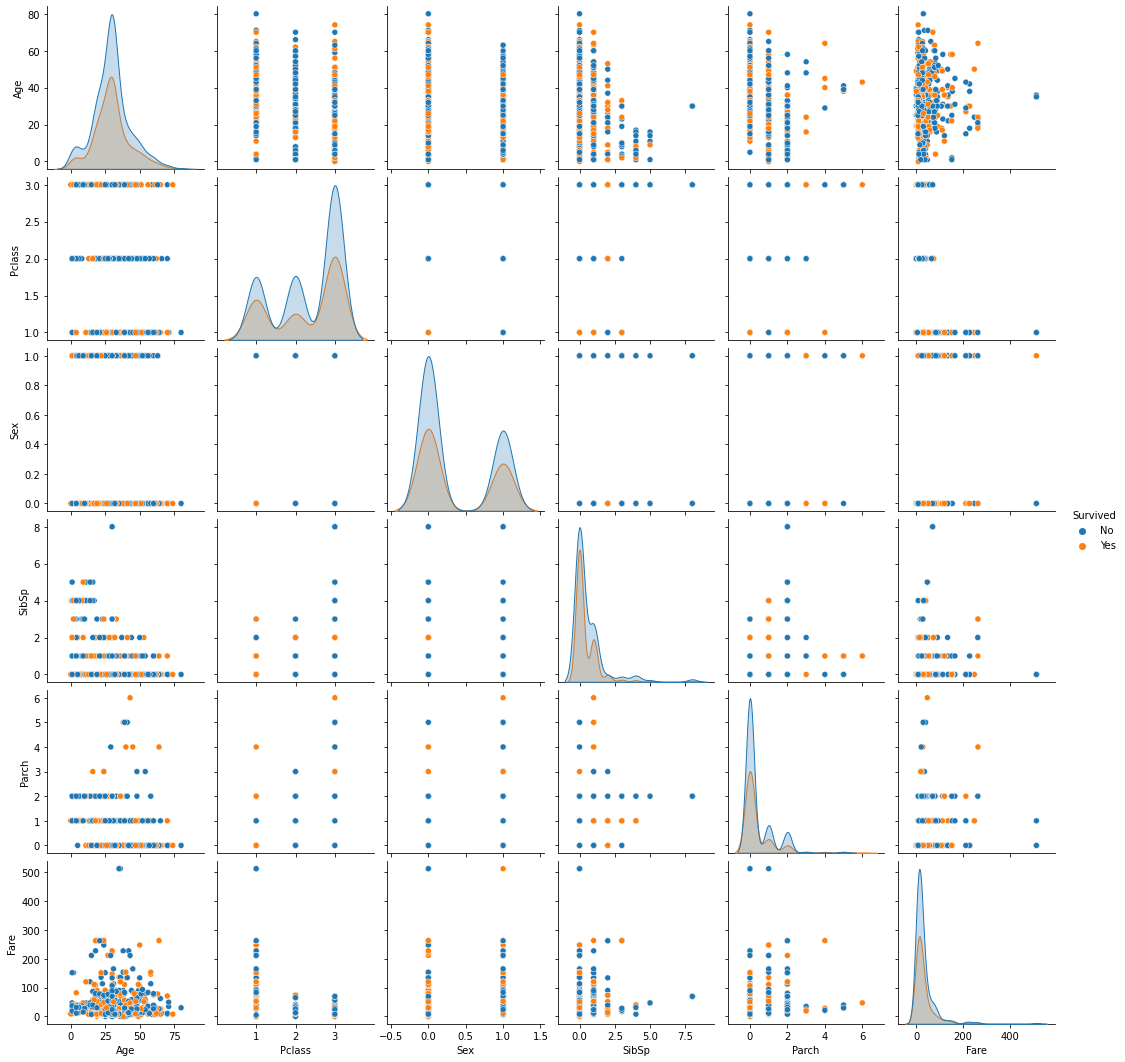

In [34]:
new_df = new_df.drop(columns=['Cabin', 'Ticket', 'Embarked'])
new_df['Sex'] = new_df['Sex'].apply(lambda x: 1 if x == 'female' else 0)
sns.pairplot(new_df, hue='Survived')

## Normalizando os dados

Nesta fase vamos deixar os dados em uma mesma escala, para evitar que os valores tenham pesos desproporcionais. Porém, agora vamos volta a utilizar os dados que foram transformados.

Verificando a discrepância entre o valor máximo e mínimo.

In [35]:
np.max(X_trans.values), np.min(X_trans.values)

(512.3292, 0.0)

Para isso vamos utilizar a biblioteca *sklearn* do módulo *preprocessing*.

In [36]:
ss = StandardScaler()
ss.fit(X_trans)
X_ss = ss.transform(X_trans)

In [37]:
np.max(X_ss), np.min(X_ss)

(29.79932885150268, -2.292322083330364)

## Visualização com PCA - ***Principal Component Analysis***

In [38]:
pca = PCA(n_components=2)
pca.fit(X_ss)

PCA(n_components=2)

In [39]:
X_pca = pca.transform(X_ss)
X_pca

array([[-1.91423869, -0.60046665],
       [ 4.74564488,  0.79180932],
       [-0.93356882,  1.55738959],
       ...,
       [-0.65432198,  2.60258466],
       [ 3.3031313 , -1.96675393],
       [-1.70239835, -0.25915587]])

In [40]:
X_pca.shape

(889, 2)

In [41]:
X_pca_df = pd.DataFrame(X_pca, columns=['PC 00', 'PC 01'])
X_pca_df

,PC 00,PC 01
0,-1.914239,-0.600467
1,4.745645,0.791809
2,-0.933569,1.557390
3,3.311052,-0.056496
4,-1.741860,-1.351552
...,...,...
884,-1.184027,-1.370371
885,3.001717,0.423198
886,-0.654322,2.602585
887,3.303131,-1.966754


<AxesSubplot:xlabel='PC 00', ylabel='PC 01'>

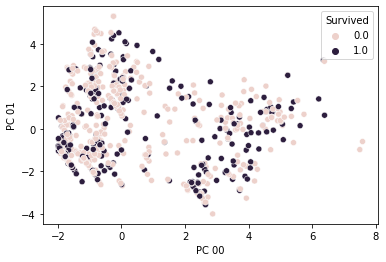

In [42]:
# 0 = No, 1 = Yes
sns.scatterplot(data=X_pca_df, x='PC 00', y='PC 01', hue=Y_train['Survived'])

 ## Classificando os dados com classificadores diferentes

In [85]:
rf_test = ('rf', RandomForestClassifier, False, {'criterion' : ['gini', 'entropy'], 'random_state' : [1]})
rf_test_scale = ('rf_scale', RandomForestClassifier, True, {'criterion' : ['gini', 'entropy'], 'random_state' : [1]})
ad_def_test = ('ad_default', DecisionTreeClassifier, False, {'criterion' : ['gini', 'entropy'], 'random_state' : [1]})
ad_def_test_scale = ('ad_default_scale', DecisionTreeClassifier, True, {'criterion' : ['gini', 'entropy'], 'random_state' : [1]})
ad_tuned_test = ('ad_tuned', DecisionTreeClassifier, False, {'min_samples_leaf' : [3, 5, 10, 15, 20, 30],
                                                 'min_samples_split' : [2, 4, 8, 16, 32, 40],
                                                 'max_depth' : [None, 2, 3, 4, 5],
                                                 'criterion' : ['gini', 'entropy'], 'random_state' : [1]})
ad_tuned_test_scale = ('ad_tuned_scale', DecisionTreeClassifier, True, {'min_samples_leaf' : [3, 5, 10, 15, 20, 30],
                                                 'min_samples_split' : [2, 4, 8, 16, 32, 40],
                                                 'max_depth' : [None, 2, 3, 4, 5],
                                                 'criterion' : ['gini', 'entropy'], 'random_state' : [1]})
svm_test = ('svm', SVC, True, {'C' : [1, 10, 100, 1000], 'gamma' : ['auto', 'scale']})
svm_test_1 = ('svm_2', SVC, True, {'C' : [0.001, 0.001, 0.01, 1, 10, 100, 1000], 'gamma' : ['auto', 'scale']})
svm_test_kernel = ('svm_kernel', SVC, True, {'C' : [1, 10, 100, 1000], 'gamma' : ['auto', 'scale'], 'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']})
knn_test = ('knn', KNeighborsClassifier, True, {'n_neighbors' : range(1,30,2)})
knn_test_2 = ('knn_2', KNeighborsClassifier, True, {'n_neighbors' : range(1,30,1)})
knn_test_3 = ('knn_3', KNeighborsClassifier, True, {'n_neighbors' : range(1,60,2)})
tests = [rf_test, rf_test_scale, ad_def_test, ad_def_test_scale, ad_tuned_test, ad_tuned_test_scale, 
         svm_test, svm_test_1, knn_test, knn_test_2, knn_test_3]

In [44]:
y = Y_train['Survived'].values.ravel()

In [45]:
resultados = {}
for nome, classificador, scale, params in tests:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 20, 20, 8, scale, params)
    resultados[nome] = r

svm_kernel


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

rf


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

rf_scale


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

ad_default


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

ad_default_scale


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

ad_tuned


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

ad_tuned_scale


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

svm


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

svm_2


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

knn


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

knn_3


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

In [46]:
for teste in resultados:
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

svm_kernel - Resultados: 0.71 +- 0.10, min: 0.52, max: 0.85
        rf - Resultados: 0.71 +- 0.09, min: 0.55, max: 0.87
  rf_scale - Resultados: 0.71 +- 0.09, min: 0.55, max: 0.87
ad_default - Resultados: 0.66 +- 0.07, min: 0.53, max: 0.76
ad_default_scale - Resultados: 0.66 +- 0.07, min: 0.53, max: 0.76
  ad_tuned - Resultados: 0.71 +- 0.08, min: 0.56, max: 0.83
ad_tuned_scale - Resultados: 0.71 +- 0.08, min: 0.56, max: 0.83
       svm - Resultados: 0.71 +- 0.10, min: 0.52, max: 0.85
     svm_2 - Resultados: 0.71 +- 0.10, min: 0.52, max: 0.85
       knn - Resultados: 0.74 +- 0.09, min: 0.57, max: 0.89
     knn_2 - Resultados: 0.74 +- 0.09, min: 0.57, max: 0.89
     knn_3 - Resultados: 0.74 +- 0.09, min: 0.57, max: 0.89


In [47]:
resultados = {}
for nome, classificador, scale, params in tests:
    r = do_cv(classificador, X_ss, y, 10, 10, 8, scale, params)
    resultados[nome] = r

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for teste in resultados:
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

In [65]:
knn_test = ('knn', KNeighborsClassifier, True, {'n_neighbors' : range(1,30,2)})
knn_test_2 = ('knn_2', KNeighborsClassifier, True, {'n_neighbors' : range(1,30,1)})

knn_test_new = ('knn_new', KNeighborsClassifier, True, {'n_neighbors' : range(15,30,2)})
knn_test_new_2 = ('knn_new_2', KNeighborsClassifier, True, {'n_neighbors' : range(15,30,1)})

knn_test_new_3 = ('knn_new_3', KNeighborsClassifier, True, {'n_neighbors' : range(1,15,2)})
knn_test_new_4 = ('knn_new_4', KNeighborsClassifier, True, {'n_neighbors' : range(1,15,1)})

knn_test_new_5 = ('knn_new_5', KNeighborsClassifier, True, {'n_neighbors' : range(1,10,2)})
knn_test_new_6 = ('knn_new_6', KNeighborsClassifier, True, {'n_neighbors' : range(1,10,1)})

knn_test_new_7 = ('knn_new_7', KNeighborsClassifier, True, {'n_neighbors' : range(5,15,2)})
knn_test_new_8 = ('knn_new_8', KNeighborsClassifier, True, {'n_neighbors' : range(5,15,1)})

knn_test_new_9 = ('knn_new_9', KNeighborsClassifier, True, {'n_neighbors' : range(5,10,2)})
knn_test_new_10 = ('knn_new_10', KNeighborsClassifier, True, {'n_neighbors' : range(5,10,1)})
tests_knn = [knn_test, knn_test_2, knn_test_new, knn_test_new_2, knn_test_new_3, knn_test_new_4, 
            knn_test_new_5, knn_test_new_6, knn_test_new_7, knn_test_new_8, knn_test_new_9, knn_test_new_10]

In [57]:
resultados = {}
for nome, classificador, scale, params in tests_knn:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 20, 20, 8, scale, params)
    resultados[nome] = r

knn


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

knn_3


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

knn_new


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

knn_new_2


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

knn_new_3


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

knn_new_4


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

knn_new_5


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

knn_new_6


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

knn_new_7


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

knn_new_8


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

knn_new_9


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

knn_new_10


Folds avaliados:   0%|          | 0/20 [00:00<?, ?it/s]

In [58]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                 knn - Resultados: 0.74 +- 0.09, min: 0.57, max: 0.89
               knn_2 - Resultados: 0.74 +- 0.09, min: 0.57, max: 0.89
               knn_3 - Resultados: 0.74 +- 0.09, min: 0.57, max: 0.89
             knn_new - Resultados: 0.69 +- 0.10, min: 0.53, max: 0.84
           knn_new_2 - Resultados: 0.69 +- 0.10, min: 0.53, max: 0.85
           knn_new_3 - Resultados: 0.74 +- 0.09, min: 0.57, max: 0.89
           knn_new_4 - Resultados: 0.74 +- 0.09, min: 0.57, max: 0.89
           knn_new_5 - Resultados: 0.74 +- 0.09, min: 0.57, max: 0.89
           knn_new_6 - Resultados: 0.74 +- 0.09, min: 0.57, max: 0.89
           knn_new_7 - Resultados: 0.72 +- 0.10, min: 0.50, max: 0.91
           knn_new_8 - Resultados: 0.72 +- 0.10, min: 0.50, max: 0.91
           knn_new_9 - Resultados: 0.72 +- 0.10, min: 0.50, max: 0.91
          knn_new_10 - Resultados: 0.72 +- 0.10, min: 0.50, max: 0.91


In [59]:
resultados = {}
for nome, classificador, scale, params in tests_knn:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 10, 10, 8, scale, params)
    resultados[nome] = r

knn


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_3


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_2


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_3


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_4


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_5


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_6


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_7


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_8


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_9


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_10


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [60]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                 knn - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
               knn_2 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
               knn_3 - Resultados: 0.75 +- 0.04, min: 0.67, max: 0.81
             knn_new - Resultados: 0.69 +- 0.06, min: 0.58, max: 0.79
           knn_new_2 - Resultados: 0.69 +- 0.06, min: 0.58, max: 0.79
           knn_new_3 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
           knn_new_4 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
           knn_new_5 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
           knn_new_6 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
           knn_new_7 - Resultados: 0.70 +- 0.05, min: 0.59, max: 0.76
           knn_new_8 - Resultados: 0.70 +- 0.06, min: 0.59, max: 0.76
           knn_new_9 - Resultados: 0.71 +- 0.06, min: 0.59, max: 0.76
          knn_new_10 - Resultados: 0.71 +- 0.06, min: 0.59, max: 0.76


In [61]:
resultados = {}
for nome, classificador, scale, params in tests_knn:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 30, 30, 8, scale, params)
    resultados[nome] = r

knn


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_3


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_2


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_3


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_4


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_5


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_6


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_7


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_8


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_9


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_10


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

In [62]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                 knn - Resultados: 0.75 +- 0.10, min: 0.56, max: 0.92
               knn_2 - Resultados: 0.75 +- 0.10, min: 0.56, max: 0.92
               knn_3 - Resultados: 0.75 +- 0.10, min: 0.56, max: 0.92
             knn_new - Resultados: 0.70 +- 0.10, min: 0.48, max: 0.92
           knn_new_2 - Resultados: 0.69 +- 0.11, min: 0.48, max: 0.92
           knn_new_3 - Resultados: 0.75 +- 0.10, min: 0.56, max: 0.92
           knn_new_4 - Resultados: 0.75 +- 0.10, min: 0.56, max: 0.92
           knn_new_5 - Resultados: 0.75 +- 0.10, min: 0.56, max: 0.92
           knn_new_6 - Resultados: 0.75 +- 0.10, min: 0.56, max: 0.92
           knn_new_7 - Resultados: 0.73 +- 0.10, min: 0.48, max: 0.91
           knn_new_8 - Resultados: 0.73 +- 0.10, min: 0.48, max: 0.91
           knn_new_9 - Resultados: 0.73 +- 0.10, min: 0.48, max: 0.91
          knn_new_10 - Resultados: 0.73 +- 0.10, min: 0.48, max: 0.91


In [63]:
resultados = {}
for nome, classificador, scale, params in tests_knn:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 100, 100, 8, scale, params)
    resultados[nome] = r

knn


Folds avaliados:   0%|          | 0/100 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/100 [00:00<?, ?it/s]

knn_3


Folds avaliados:   0%|          | 0/100 [00:00<?, ?it/s]

knn_new


Folds avaliados:   0%|          | 0/100 [00:00<?, ?it/s]

knn_new_2


Folds avaliados:   0%|          | 0/100 [00:00<?, ?it/s]

knn_new_3


Folds avaliados:   0%|          | 0/100 [00:00<?, ?it/s]

knn_new_4


Folds avaliados:   0%|          | 0/100 [00:00<?, ?it/s]

knn_new_5


Folds avaliados:   0%|          | 0/100 [00:00<?, ?it/s]

knn_new_6


Folds avaliados:   0%|          | 0/100 [00:00<?, ?it/s]

knn_new_7


Folds avaliados:   0%|          | 0/100 [00:00<?, ?it/s]

knn_new_8


Folds avaliados:   0%|          | 0/100 [00:00<?, ?it/s]

knn_new_9


Folds avaliados:   0%|          | 0/100 [00:00<?, ?it/s]

knn_new_10


Folds avaliados:   0%|          | 0/100 [00:00<?, ?it/s]

In [64]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                 knn - Resultados: 0.74 +- 0.18, min: 0.33, max: 1.00
               knn_2 - Resultados: 0.74 +- 0.18, min: 0.33, max: 1.00
               knn_3 - Resultados: 0.74 +- 0.18, min: 0.33, max: 1.00
             knn_new - Resultados: 0.69 +- 0.18, min: 0.33, max: 1.00
           knn_new_2 - Resultados: 0.69 +- 0.18, min: 0.33, max: 1.00
           knn_new_3 - Resultados: 0.74 +- 0.18, min: 0.33, max: 1.00
           knn_new_4 - Resultados: 0.74 +- 0.18, min: 0.33, max: 1.00
           knn_new_5 - Resultados: 0.74 +- 0.18, min: 0.33, max: 1.00
           knn_new_6 - Resultados: 0.74 +- 0.18, min: 0.33, max: 1.00
           knn_new_7 - Resultados: 0.72 +- 0.19, min: 0.29, max: 1.00
           knn_new_8 - Resultados: 0.72 +- 0.19, min: 0.29, max: 1.00
           knn_new_9 - Resultados: 0.72 +- 0.19, min: 0.29, max: 1.00
          knn_new_10 - Resultados: 0.72 +- 0.19, min: 0.29, max: 1.00


In [66]:
resultados = {}
for nome, classificador, scale, params in tests_knn:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 50, 50, 8, scale, params)
    resultados[nome] = r

knn


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_2


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_3


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_4


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_5


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_6


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_7


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_8


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_9


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_10


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

In [67]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                 knn - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
               knn_2 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
             knn_new - Resultados: 0.68 +- 0.15, min: 0.40, max: 1.00
           knn_new_2 - Resultados: 0.69 +- 0.16, min: 0.40, max: 1.00
           knn_new_3 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_4 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_5 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_6 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_7 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
           knn_new_8 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
           knn_new_9 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
          knn_new_10 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00


In [68]:
resultados = {}
for nome, classificador, scale, params in tests_knn:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 40, 40, 8, scale, params)
    resultados[nome] = r

knn


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_2


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_3


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_4


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_5


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_6


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_7


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_8


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_9


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_10


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

In [69]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                 knn - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
               knn_2 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
             knn_new - Resultados: 0.68 +- 0.14, min: 0.36, max: 0.94
           knn_new_2 - Resultados: 0.68 +- 0.14, min: 0.36, max: 0.94
           knn_new_3 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
           knn_new_4 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
           knn_new_5 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
           knn_new_6 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
           knn_new_7 - Resultados: 0.73 +- 0.13, min: 0.50, max: 1.00
           knn_new_8 - Resultados: 0.73 +- 0.13, min: 0.50, max: 1.00
           knn_new_9 - Resultados: 0.73 +- 0.13, min: 0.50, max: 1.00
          knn_new_10 - Resultados: 0.73 +- 0.13, min: 0.50, max: 1.00


In [70]:
resultados = {}
for nome, classificador, scale, params in tests_knn:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 45, 45, 8, scale, params)
    resultados[nome] = r

knn


Folds avaliados:   0%|          | 0/45 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/45 [00:00<?, ?it/s]

knn_new


Folds avaliados:   0%|          | 0/45 [00:00<?, ?it/s]

knn_new_2


Folds avaliados:   0%|          | 0/45 [00:00<?, ?it/s]

knn_new_3


Folds avaliados:   0%|          | 0/45 [00:00<?, ?it/s]

knn_new_4


Folds avaliados:   0%|          | 0/45 [00:00<?, ?it/s]

knn_new_5


Folds avaliados:   0%|          | 0/45 [00:00<?, ?it/s]

knn_new_6


Folds avaliados:   0%|          | 0/45 [00:00<?, ?it/s]

knn_new_7


Folds avaliados:   0%|          | 0/45 [00:00<?, ?it/s]

knn_new_8


Folds avaliados:   0%|          | 0/45 [00:00<?, ?it/s]

knn_new_9


Folds avaliados:   0%|          | 0/45 [00:00<?, ?it/s]

knn_new_10


Folds avaliados:   0%|          | 0/45 [00:00<?, ?it/s]

In [71]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                 knn - Resultados: 0.74 +- 0.13, min: 0.50, max: 0.94
               knn_2 - Resultados: 0.74 +- 0.13, min: 0.50, max: 0.94
             knn_new - Resultados: 0.69 +- 0.13, min: 0.31, max: 1.00
           knn_new_2 - Resultados: 0.69 +- 0.13, min: 0.31, max: 1.00
           knn_new_3 - Resultados: 0.74 +- 0.13, min: 0.50, max: 0.94
           knn_new_4 - Resultados: 0.74 +- 0.13, min: 0.50, max: 0.94
           knn_new_5 - Resultados: 0.74 +- 0.13, min: 0.50, max: 0.94
           knn_new_6 - Resultados: 0.74 +- 0.13, min: 0.50, max: 0.94
           knn_new_7 - Resultados: 0.73 +- 0.13, min: 0.53, max: 0.94
           knn_new_8 - Resultados: 0.73 +- 0.13, min: 0.53, max: 0.94
           knn_new_9 - Resultados: 0.73 +- 0.13, min: 0.53, max: 0.94
          knn_new_10 - Resultados: 0.73 +- 0.13, min: 0.53, max: 0.94


In [72]:
resultados = {}
for nome, classificador, scale, params in tests_knn:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 10, 30, 8, scale, params)
    resultados[nome] = r

knn


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_2


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_3


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_4


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_5


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_6


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_7


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_8


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_9


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_10


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [73]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                 knn - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
               knn_2 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
             knn_new - Resultados: 0.69 +- 0.07, min: 0.58, max: 0.81
           knn_new_2 - Resultados: 0.69 +- 0.06, min: 0.58, max: 0.81
           knn_new_3 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
           knn_new_4 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
           knn_new_5 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
           knn_new_6 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
           knn_new_7 - Resultados: 0.71 +- 0.06, min: 0.59, max: 0.76
           knn_new_8 - Resultados: 0.71 +- 0.06, min: 0.59, max: 0.76
           knn_new_9 - Resultados: 0.71 +- 0.06, min: 0.59, max: 0.76
          knn_new_10 - Resultados: 0.71 +- 0.06, min: 0.59, max: 0.76


In [74]:
resultados = {}
for nome, classificador, scale, params in tests_knn:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 30, 10, 8, scale, params)
    resultados[nome] = r

knn


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_2


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_3


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_4


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_5


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_6


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_7


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_8


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_9


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

knn_new_10


Folds avaliados:   0%|          | 0/30 [00:00<?, ?it/s]

In [75]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                 knn - Resultados: 0.74 +- 0.10, min: 0.56, max: 0.92
               knn_2 - Resultados: 0.74 +- 0.12, min: 0.44, max: 0.92
             knn_new - Resultados: 0.68 +- 0.10, min: 0.38, max: 0.87
           knn_new_2 - Resultados: 0.68 +- 0.11, min: 0.38, max: 0.87
           knn_new_3 - Resultados: 0.74 +- 0.10, min: 0.56, max: 0.92
           knn_new_4 - Resultados: 0.74 +- 0.12, min: 0.44, max: 0.92
           knn_new_5 - Resultados: 0.74 +- 0.10, min: 0.56, max: 0.92
           knn_new_6 - Resultados: 0.74 +- 0.12, min: 0.44, max: 0.92
           knn_new_7 - Resultados: 0.73 +- 0.10, min: 0.48, max: 0.91
           knn_new_8 - Resultados: 0.73 +- 0.10, min: 0.48, max: 0.91
           knn_new_9 - Resultados: 0.73 +- 0.10, min: 0.48, max: 0.91
          knn_new_10 - Resultados: 0.73 +- 0.10, min: 0.48, max: 0.91


In [76]:
resultados = {}
for nome, classificador, scale, params in tests_knn:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 40, 10, 8, scale, params)
    resultados[nome] = r

knn


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_2


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_3


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_4


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_5


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_6


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_7


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_8


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_9


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_new_10


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

In [77]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                 knn - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
               knn_2 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
             knn_new - Resultados: 0.69 +- 0.15, min: 0.20, max: 0.94
           knn_new_2 - Resultados: 0.69 +- 0.15, min: 0.20, max: 0.94
           knn_new_3 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
           knn_new_4 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
           knn_new_5 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
           knn_new_6 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
           knn_new_7 - Resultados: 0.72 +- 0.14, min: 0.38, max: 1.00
           knn_new_8 - Resultados: 0.72 +- 0.14, min: 0.38, max: 1.00
           knn_new_9 - Resultados: 0.72 +- 0.14, min: 0.38, max: 1.00
          knn_new_10 - Resultados: 0.72 +- 0.14, min: 0.38, max: 1.00


In [78]:
resultados = {}
for nome, classificador, scale, params in tests_knn:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 50, 10, 8, scale, params)
    resultados[nome] = r

knn


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_2


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_3


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_4


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_5


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_6


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_7


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_8


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_9


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_10


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

In [79]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                 knn - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
               knn_2 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
             knn_new - Resultados: 0.68 +- 0.15, min: 0.43, max: 1.00
           knn_new_2 - Resultados: 0.68 +- 0.15, min: 0.43, max: 1.00
           knn_new_3 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_4 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_5 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_6 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_7 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
           knn_new_8 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
           knn_new_9 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
          knn_new_10 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00


In [80]:
resultados = {}
for nome, classificador, scale, params in tests_knn:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 50, 15, 8, scale, params)
    resultados[nome] = r

knn


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_2


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_3


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_4


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_5


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_6


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_7


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_8


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_9


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_10


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

In [81]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                 knn - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
               knn_2 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
             knn_new - Resultados: 0.69 +- 0.15, min: 0.40, max: 1.00
           knn_new_2 - Resultados: 0.68 +- 0.15, min: 0.40, max: 1.00
           knn_new_3 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_4 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_5 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_6 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_7 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
           knn_new_8 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
           knn_new_9 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
          knn_new_10 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00


In [93]:
resultados = {}
for nome, classificador, scale, params in tests_knn:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 50, 30, 8, scale, params)
    resultados[nome] = r

knn


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_2


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_3


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_4


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_5


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_6


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_7


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_8


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_9


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_new_10


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

In [94]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                 knn - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
               knn_2 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
             knn_new - Resultados: 0.69 +- 0.15, min: 0.46, max: 1.00
           knn_new_2 - Resultados: 0.69 +- 0.15, min: 0.46, max: 1.00
           knn_new_3 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_4 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_5 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_6 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
           knn_new_7 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
           knn_new_8 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
           knn_new_9 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
          knn_new_10 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00


In [83]:
resultados = {}
for nome, classificador, scale, params in tests_knn:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 10, 50, 8, scale, params)
    resultados[nome] = r

knn


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_2


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_3


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_4


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_5


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_6


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_7


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_8


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_9


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_new_10


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [84]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                 knn - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
               knn_2 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
             knn_new - Resultados: 0.69 +- 0.07, min: 0.58, max: 0.81
           knn_new_2 - Resultados: 0.69 +- 0.07, min: 0.57, max: 0.81
           knn_new_3 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
           knn_new_4 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
           knn_new_5 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
           knn_new_6 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
           knn_new_7 - Resultados: 0.71 +- 0.06, min: 0.59, max: 0.76
           knn_new_8 - Resultados: 0.71 +- 0.06, min: 0.59, max: 0.76
           knn_new_9 - Resultados: 0.71 +- 0.06, min: 0.59, max: 0.76
          knn_new_10 - Resultados: 0.71 +- 0.06, min: 0.59, max: 0.76


In [87]:
resultados = {}
for nome, classificador, scale, params in tests:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 40, 10, 8, scale, params)
    resultados[nome] = r

rf


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

rf_scale


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

ad_default


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

ad_default_scale


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

ad_tuned


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

ad_tuned_scale


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

svm


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

svm_2


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_3


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

In [88]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                  rf - Resultados: 0.71 +- 0.14, min: 0.36, max: 0.95
            rf_scale - Resultados: 0.71 +- 0.14, min: 0.36, max: 0.95
          ad_default - Resultados: 0.65 +- 0.12, min: 0.43, max: 0.86
    ad_default_scale - Resultados: 0.65 +- 0.12, min: 0.43, max: 0.86
            ad_tuned - Resultados: 0.72 +- 0.12, min: 0.35, max: 0.93
      ad_tuned_scale - Resultados: 0.72 +- 0.12, min: 0.35, max: 0.93
                 svm - Resultados: 0.71 +- 0.15, min: 0.33, max: 0.94
               svm_2 - Resultados: 0.71 +- 0.15, min: 0.33, max: 0.94
                 knn - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
               knn_2 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
               knn_3 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95


In [89]:
resultados = {}
for nome, classificador, scale, params in tests:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 10, 30, 8, scale, params)
    resultados[nome] = r

rf


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

rf_scale


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

ad_default


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

ad_default_scale


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

ad_tuned


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

ad_tuned_scale


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

svm


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

svm_2


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

knn_3


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [90]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                  rf - Resultados: 0.72 +- 0.06, min: 0.58, max: 0.79
            rf_scale - Resultados: 0.72 +- 0.06, min: 0.58, max: 0.79
          ad_default - Resultados: 0.66 +- 0.06, min: 0.55, max: 0.76
    ad_default_scale - Resultados: 0.66 +- 0.06, min: 0.55, max: 0.76
            ad_tuned - Resultados: 0.73 +- 0.04, min: 0.66, max: 0.79
      ad_tuned_scale - Resultados: 0.73 +- 0.04, min: 0.66, max: 0.79
                 svm - Resultados: 0.71 +- 0.07, min: 0.58, max: 0.81
               svm_2 - Resultados: 0.71 +- 0.07, min: 0.58, max: 0.81
                 knn - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
               knn_2 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81
               knn_3 - Resultados: 0.74 +- 0.04, min: 0.67, max: 0.81


In [91]:
resultados = {}
for nome, classificador, scale, params in tests:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 50, 50, 8, scale, params)
    resultados[nome] = r

rf


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

rf_scale


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

ad_default


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

ad_default_scale


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

ad_tuned


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

ad_tuned_scale


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

svm


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

svm_2


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_3


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

In [92]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

                  rf - Resultados: 0.71 +- 0.15, min: 0.36, max: 1.00
            rf_scale - Resultados: 0.71 +- 0.15, min: 0.36, max: 1.00
          ad_default - Resultados: 0.63 +- 0.14, min: 0.22, max: 0.88
    ad_default_scale - Resultados: 0.63 +- 0.14, min: 0.22, max: 0.88
            ad_tuned - Resultados: 0.72 +- 0.15, min: 0.43, max: 1.00
      ad_tuned_scale - Resultados: 0.72 +- 0.15, min: 0.43, max: 1.00
                 svm - Resultados: 0.71 +- 0.16, min: 0.36, max: 1.00
               svm_2 - Resultados: 0.71 +- 0.16, min: 0.36, max: 1.00
                 knn - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
               knn_2 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
               knn_3 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00


In [103]:
knn_imp = ('knn_1', KNeighborsClassifier, True, {'n_neighbors' : range(1,5,1)})
knn_imp_2 = ('knn_2', KNeighborsClassifier, True, {'n_neighbors' : range(1,5,2)})

knn_imp_3 = ('knn_3', KNeighborsClassifier, True, {'n_neighbors' : range(5,10,1)})
knn_imp_4 = ('knn_4', KNeighborsClassifier, True, {'n_neighbors' : range(5,10,2)})

knn_imp_6 = ('knn_6', KNeighborsClassifier, True, {'n_neighbors' : range(10,15,2)})

knn_imp_7 = ('knn_7', KNeighborsClassifier, True, {'n_neighbors' : range(3,5,1)})
knn_imp_8 = ('knn_8', KNeighborsClassifier, True, {'n_neighbors' : range(3,5,2)})

knn_imp_9 = ('knn_9', KNeighborsClassifier, True, {'n_neighbors' : range(5,8,1)})
knn_imp_10 = ('knn_10', KNeighborsClassifier, True, {'n_neighbors' : range(5,8,2)})
tests_knn_imp = [knn_imp, knn_imp_2, knn_imp_3, knn_imp_4, knn_imp_6, knn_imp_7, 
               knn_imp_8, knn_imp_9, knn_imp_10]

In [104]:
resultados = {}
for nome, classificador, scale, params in tests_knn_imp:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 50, 30, 8, scale, params)
    resultados[nome] = r

knn_1


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_3


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_4


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_6


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_7


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_8


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_9


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_10


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

In [105]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

               knn_1 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
               knn_2 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
               knn_3 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
               knn_4 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
               knn_6 - Resultados: 0.68 +- 0.16, min: 0.40, max: 1.00
               knn_7 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
               knn_8 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
               knn_9 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
              knn_10 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00


In [106]:
resultados = {}
for nome, classificador, scale, params in tests_knn_imp:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 50, 10, 8, scale, params)
    resultados[nome] = r

knn_1


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_3


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_4


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_6


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_7


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_8


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_9


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

knn_10


Folds avaliados:   0%|          | 0/50 [00:00<?, ?it/s]

In [107]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

               knn_1 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
               knn_2 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
               knn_3 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
               knn_4 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
               knn_6 - Resultados: 0.68 +- 0.15, min: 0.40, max: 1.00
               knn_7 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
               knn_8 - Resultados: 0.74 +- 0.13, min: 0.40, max: 1.00
               knn_9 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00
              knn_10 - Resultados: 0.73 +- 0.14, min: 0.44, max: 1.00


In [110]:
resultados = {}
for nome, classificador, scale, params in tests_knn_imp:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 40, 50, 8, scale, params)
    resultados[nome] = r

knn_1


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_3


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_4


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_6


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_7


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_8


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_9


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_10


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

In [111]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

               knn_1 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
               knn_2 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
               knn_3 - Resultados: 0.73 +- 0.13, min: 0.50, max: 1.00
               knn_4 - Resultados: 0.73 +- 0.13, min: 0.50, max: 1.00
               knn_6 - Resultados: 0.66 +- 0.15, min: 0.18, max: 0.94
               knn_7 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
               knn_8 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
               knn_9 - Resultados: 0.73 +- 0.13, min: 0.50, max: 1.00
              knn_10 - Resultados: 0.73 +- 0.13, min: 0.50, max: 1.00


In [116]:
resultados = {}
for nome, classificador, scale, params in tests_knn_imp:
    print(nome)
    r = do_cv(classificador, X_pca_df.values, y, 40, 100, 8, scale, params)
    resultados[nome] = r

knn_1


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_3


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_4


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_6


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_7


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_8


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_9


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_10


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

In [117]:
for teste in resultados:
    print(teste.rjust(20), end=' - ')
    imprimir_estatisticas(resultados[teste])

               knn_1 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
               knn_2 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
               knn_3 - Resultados: 0.73 +- 0.13, min: 0.50, max: 1.00
               knn_4 - Resultados: 0.73 +- 0.13, min: 0.50, max: 1.00
               knn_6 - Resultados: 0.67 +- 0.15, min: 0.18, max: 0.94
               knn_7 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
               knn_8 - Resultados: 0.74 +- 0.12, min: 0.50, max: 0.95
               knn_9 - Resultados: 0.73 +- 0.13, min: 0.50, max: 1.00
              knn_10 - Resultados: 0.73 +- 0.13, min: 0.50, max: 1.00


In [118]:
resultados = {}
for nome, classificador, scale, params in tests_knn_imp:
    print(nome)
    r = do_cv(classificador, X_ss, y, 40, 100, 8, scale, params)
    resultados[nome] = r

knn_1


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_2


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_3


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_4


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_6


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_7


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_8


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_9


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

knn_10


Folds avaliados:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
X_ss